# Simulate the observations
Run these in a handful of filters and with/without coronagraphy.
Here we assume that the scene has been created elsewhere.

In [1]:
import json
import matplotlib.pyplot as plt
import copy
import numpy as np
import multiprocessing as mp
import pickle

import pandisk as pd
import pandeia.engine
import jwst_pancake as pc

%load_ext autoreload
%autoreload 2
%matplotlib inline

## setup

In [2]:
# MIRI pixel scale
# https://jwst-docs.stsci.edu/mid-infrared-instrument/miri-observing-modes/miri-imaging
aspp = 0.11

In [3]:
# base observation config
cor_base = pandeia.engine.calc_utils.build_default_calc('jwst', 'miri', 'coronagraphy')
cor_base['scene'].clear()

img_base = pandeia.engine.calc_utils.build_default_calc('jwst', 'miri', 'imaging')
img_base['scene'].clear()

In [4]:
# get the scene - this is the science object
# expect a file called "X.json" and ref star file "X.ref.json"

dir = '../../../cycle1/beta-leo/'
fs = [
      '1belt-11um.json','1belt-15um.json','1belt-18um.json','1belt-21um.json','1belt-23um.json','1belt-25.5um.json',
      '2belt-11um.json','2belt-15um.json','2belt-18um.json','2belt-21um.json','2belt-23um.json','2belt-25.5um.json',
      '1narrow-11um.json','1narrow-15um.json','1narrow-18um.json','1narrow-21um.json','1narrow-23um.json','1narrow-25.5um.json',
     ]

targ_scenes = []
ref_scenes = []

for f in fs:

    with open(dir+f,'r') as f_:
        targ_scene = json.load(f_)

    # add in a global offset to capture the effect of target acquisition error.
    errx, erry = pc.scene.get_ta_error()
    pc.scene.offset_scene(targ_scene,errx,erry)
    targ_scenes.append(targ_scene)

    # same for reference star
    ref_scene = copy.deepcopy(targ_scene)
    with open(dir+f.replace('.json','.ref.json'),'r') as f_:
        ref_scene = json.load(f_)

    # And add target acquisition error
    errx_ref, erry_ref = pc.scene.get_ta_error()
    pc.scene.offset_scene(ref_scene,errx_ref,erry_ref)
    ref_scenes.append(ref_scene)

In [5]:
# lists of setups, change number of groups to limit imaging saturation,
# if the reference star is saturated the registered saturation can fail
# but avoid going below 5
# https://jwst-docs.stsci.edu/display/JPP/MIRI+Generic+Recommended+Strategies
img_sub = 'sub256' #30" sqaure
subarrays  = [ img_sub, 'mask1065',  img_sub, 'mask1550',  img_sub, 'masklyot',  img_sub,  img_sub]
apertures  = ['imager', 'fqpm1065', 'imager', 'fqpm1550', 'imager', 'lyot2300', 'imager', 'imager']
filters    = ['f1000w', 'f1065c',   'f1500w', 'f1550c',   'f1800w', 'f2300c',   'f2100w', 'f2550w']
targ_ngrps = [ 5,        100,        7,        100,        7,        100,        7,        10]
ref_ngrps  = [ 5,        100,        5,        100,        5,        100,        5,        10]

# copy the above and delete as appropriate
subarrays  = [ img_sub, 'mask1550',  img_sub,  img_sub, 'masklyot',  img_sub]
apertures  = ['imager', 'fqpm1550', 'imager', 'imager', 'lyot2300', 'imager']
filters    = ['f1500w', 'f1550c',   'f1800w', 'f2100w', 'f2300c',   'f2550w']
targ_ngrps = [ 5,        100,        5,        5,        100,        5]
ref_ngrps  = [ 5,        100,        5,        5,        100,        5]

# nint will be this/ngroups, 10,000 is approx 40-50 minutes
# for MIRI coron and sub256 subarrays
target_int = 10000
ref_int    = 10000

In [6]:
# order scenes to match observing wavelengths above

# idx = [1,1,2,3,4,5] # 1 belt
idx = [7,7,8,9,10,11] # 2 belt
# idx = [13,13,14,15,16,17] # 1 narrow

# scene_file = dir + '1belt'
scene_file = dir + '2belt'
# scene_file = dir + '1narrow'

targs = []
refs = []
for i in idx:
    targs.append(targ_scenes[i])
    refs.append(ref_scenes[i])

In [7]:
# make a list, one element per observation
target = []
targ_star = []
ref_star = []
for suba, aper, filt, tngrp, rngrp, ta, re in zip(subarrays, apertures, filters, targ_ngrps, ref_ngrps, targs, refs):

    if aper == 'imager':
        targ = copy.deepcopy(img_base)
    else:
        targ = copy.deepcopy(cor_base)

    targ['configuration']['dynamic_scene'] = True
    targ['configuration']['scene_size'] = 24.0
    targ['configuration']['max_scene_size'] = 24.0
        
    # target
    targ['configuration']['detector']['subarray'] = suba
    targ['configuration']['instrument']['aperture'] = aper
    targ['configuration']['instrument']['filter'] = filt
    targ['configuration']['detector']['ngroup'] = tngrp
    targ['configuration']['detector']['nint'] = target_int / tngrp
    targ['configuration']['detector']['readout_pattern'] = 'fast'
    targ['scene'] = copy.deepcopy(ta)

    # target star by itself
    star = copy.deepcopy(targ)
    star['scene'] = star['scene'][:1]
    
    # reference star
    ref = copy.deepcopy(targ)
    ref['configuration']['detector']['ngroup'] = rngrp
    ref['configuration']['detector']['nint'] = ref_int / rngrp
    ref['scene'] = copy.deepcopy(re)
    
    # also added to target as psf reference
    targ['strategy']['psf_subtraction_source'] = ref_scene[0]
    targ['strategy']['psf_subtraction_source']['id'] = targ['scene'][-1]['id']+1
    
    target.append(targ)
    targ_star.append(star)
    ref_star.append(ref)

## observing

### largely standard calculation

In [8]:
# additional calculation config, if we're using pandeia_coronagraphy
pc.engine.options.wave_sampling = 10        # set ~10 for speed, >50 for accuracy
pc.engine.options.on_the_fly_PSFs = False   # True to get on-the-fly PSFs, only works for coron

In [9]:
# do the calculation, gives quite a few warnings
results = pc.engine.calculate_batch(target+targ_star+ref_star)
target_results = results[:len(target)]
star_results = results[len(target):len(target)+len(targ_star)]
ref_results = results[len(target)+len(targ_star):]

/usr/local/miniconda3/envs/astroconda/lib/python3.7/site-packages/pandeia/engine/etc3D.py:1125: RuntimeWarning: invalid value encountered in sqrt
  stdev_pix = np.sqrt(var_pix)
/usr/local/miniconda3/envs/astroconda/lib/python3.7/site-packages/pandeia/engine/etc3D.py:1125: RuntimeWarning: invalid value encountered in sqrt
  stdev_pix = np.sqrt(var_pix)
/usr/local/miniconda3/envs/astroconda/lib/python3.7/site-packages/pandeia/engine/etc3D.py:1125: RuntimeWarning: invalid value encountered in sqrt
  stdev_pix = np.sqrt(var_pix)

/usr/local/miniconda3/envs/astroconda/lib/python3.7/site-packages/pandeia/engine/etc3D.py:1125: RuntimeWarning: invalid value encountered in sqrt
  stdev_pix = np.sqrt(var_pix)
/usr/local/miniconda3/envs/astroconda/lib/python3.7/site-packages/pandeia/engine/etc3D.py:1125: RuntimeWarning: invalid value encountered in sqrt
  stdev_pix = np.sqrt(var_pix)
/usr/local/miniconda3/envs/astroconda/lib/python3.7/site-packages/pandeia/engine/etc3D.py:1125: RuntimeWarning: in

In [10]:
# extract some relevant images
target_slope = []
target_snr = []
target_sat = []
star_slope = []
star_snr = []
star_sat = []
ref_slope = []  # dedicated ref obs
ref_snr = []
ref_sat = []
tref_slope = [] # ref obs bundled with target
tref_snr = []
tref_sat = []
bestsub_slope = []
for t, s, r in zip(target_results, star_results, ref_results):
    if t['input']['configuration']['instrument']['aperture'] == 'imager':
        target_slope.append(t['2d']['detector'])
        target_snr.append(t['2d']['snr'])
        target_sat.append(t['2d']['saturation'])
        star_slope.append(s['2d']['detector'])
        star_snr.append(s['2d']['snr'])
        star_sat.append(s['2d']['saturation'])
        ref_slope.append(r['2d']['detector'])
        ref_snr.append(r['2d']['snr'])
        ref_sat.append(r['2d']['saturation'])
        tref_slope.append(r['2d']['detector'])
        tref_snr.append(r['2d']['snr'])
        tref_sat.append(r['2d']['saturation'])
        bestsub_slope.append(target_slope[-1] - star_slope[-1])
    else:
        target_slope.append(t['sub_reports'][0]['2d']['detector'])
        target_snr.append(t['sub_reports'][0]['2d']['snr'])
        target_sat.append(t['sub_reports'][0]['2d']['saturation'])
        star_slope.append(s['sub_reports'][0]['2d']['detector'])
        star_snr.append(s['sub_reports'][0]['2d']['snr'])
        star_sat.append(s['sub_reports'][0]['2d']['saturation'])
        ref_slope.append(r['sub_reports'][0]['2d']['detector'])
        ref_snr.append(r['sub_reports'][0]['2d']['snr'])
        ref_sat.append(r['sub_reports'][0]['2d']['saturation'])
        tref_slope.append(r['sub_reports'][1]['2d']['detector'])
        tref_snr.append(r['sub_reports'][1]['2d']['snr'])
        tref_sat.append(r['sub_reports'][1]['2d']['saturation'])
        bestsub_slope.append(target_slope[-1] - star_slope[-1])

### using pancake SGD to create coronagraphic PSF
Compute artificial PSF for subtraction. Below is taken straight from `pancake.analysis`.

In [11]:
pc.engine.options.on_the_fly_PSFs = False

In [12]:
klip_ref = []

for conf, t_slope, ref in zip(target, target_slope, ref_results):

    # if imager just use PSF from above, subtracting background
    if conf['configuration']['instrument']['aperture'] == 'imager':
        r_tmp = pd.subtract_background(ref['2d']['detector'], aspp=aspp, radius=5)
        klip_ref.append(r_tmp*np.nanmax(t_slope)/np.nanmax(r_tmp))
        continue
        
    # sgd
    sgds = pc.scene.create_SGD(False, stepsize=0.02)

    sgd_results = [ref]
    for sgd in sgds[1:]:
        sgd_config = copy.deepcopy(conf)
        pc.scene.offset_scene([sgd_config['strategy']['psf_subtraction_source']], *sgd)
        sgd_results.append(pc.engine.calculate_reference(sgd_config))

    sgd_reg = []
    sgd_slopes = []
    for r in sgd_results:
        slope = r['2d']['detector']
        if slope.shape != t_slope.shape:
            slope = np.zeros_like(t_slope)
            slope[1:-1,1:-1] = r['2d']['detector'] # pad
        sgd_slopes.append(slope)
        mask = np.where(np.isnan(slope), 1., 0.)
        reg = pc.analysis.register_to_target(slope, t_slope, mask=mask, rescale_reference=True)
        sgd_reg.append(reg)

    sgd_reg = np.array(sgd_reg)

#     centered_target = t_slope - np.nanmean(t_slope)
    centered_target = pd.subtract_background(t_slope, aspp=aspp, radius=5)
    artificialPSF = pc.analysis.klip_projection(centered_target, sgd_reg)
    klip_ref.append(artificialPSF)

# add PSFs to results
results.append(klip_ref)

# Explore the results

## Best-case subtraction, can't do better than this!

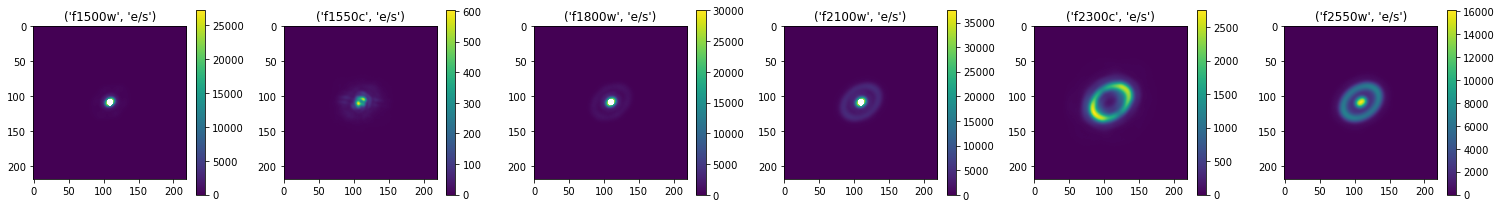

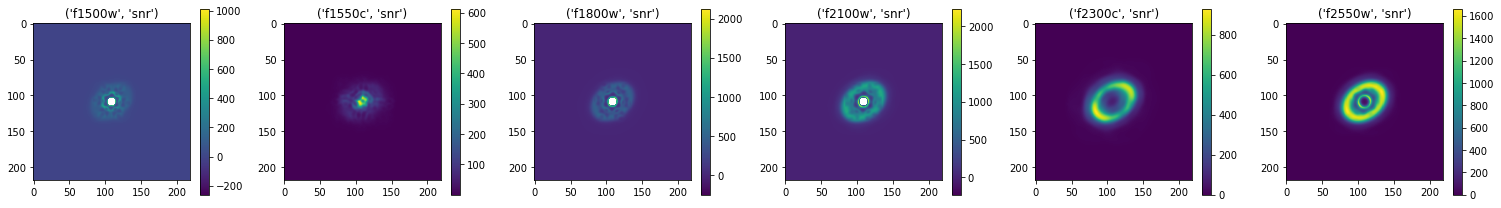

In [13]:
# best-case subtracted images
fig = pd.show_images(bestsub_slope, title=list(zip(filters,np.tile('e/s',len(filters)))))
fig.savefig(scene_file+'-subbest.pdf')
fig = pd.show_images(target_snr, sub=star_snr, title=list(zip(filters,np.tile('snr',len(filters)))))
fig.savefig(scene_file+'-subbestsnr.pdf')

## Now look at individual images, snr, saturation

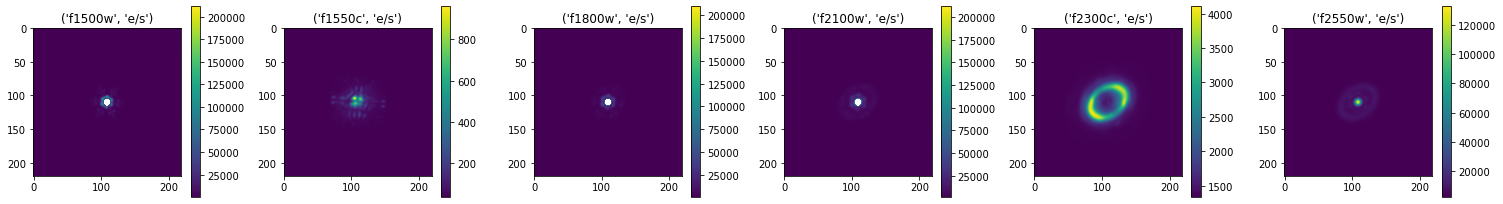

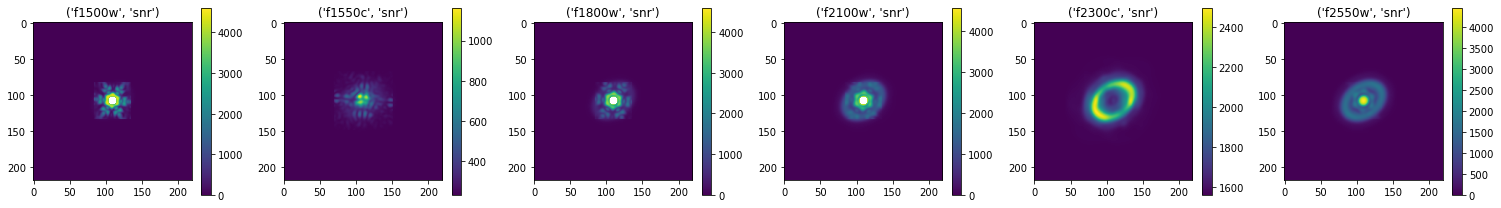

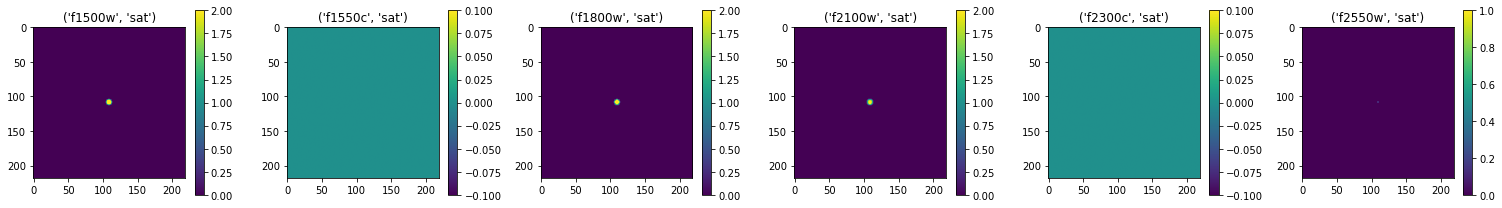

In [14]:
# target slope images
fig = pd.show_images(target_slope, title=list(zip(filters,np.tile('e/s',len(filters)))))
fig.savefig(scene_file+'-targflux.pdf')
fig = pd.show_images(target_snr, title=list(zip(filters,np.tile('snr',len(filters)))), log=False)
fig.savefig(scene_file+'-targsnr.pdf')
# fig = pd.show_images(target_snr, title=list(zip(filters,np.tile('snr',len(filters)))), log=True)
fig = pd.show_images(target_sat, title=list(zip(filters,np.tile('sat',len(filters)))))
fig.savefig(scene_file+'-targsat.pdf')

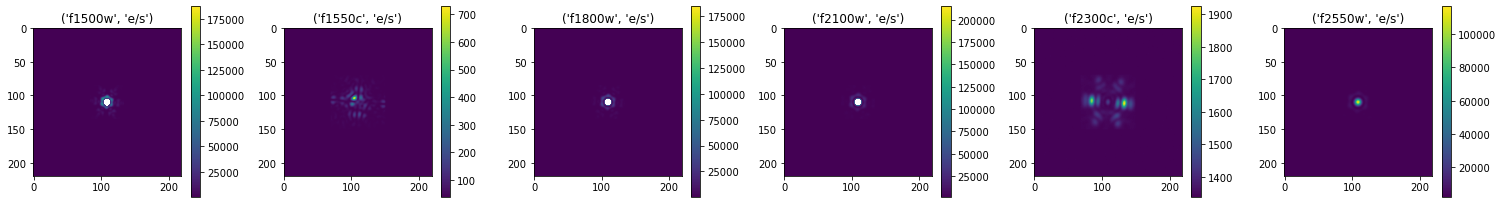

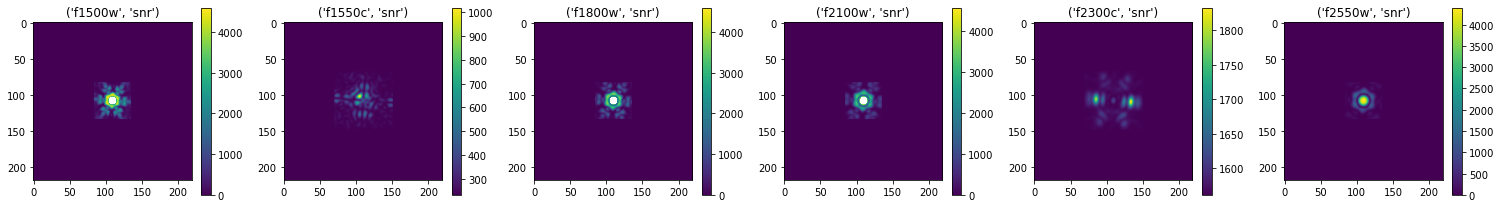

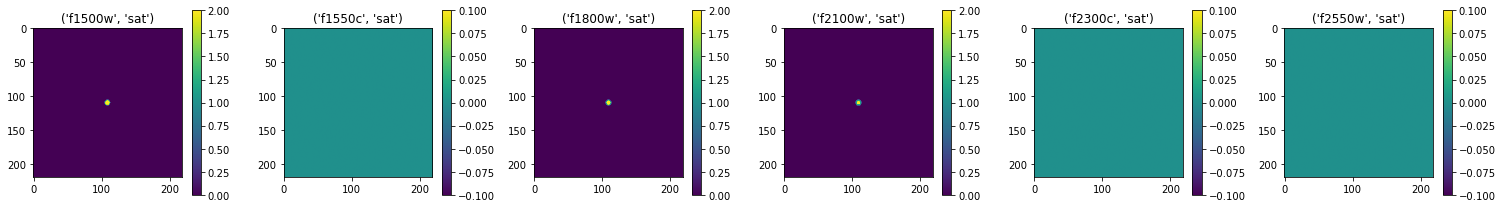

In [15]:
# star slope images
fig = pd.show_images(star_slope, title=list(zip(filters,np.tile('e/s',len(filters)))))
fig = pd.show_images(star_snr, title=list(zip(filters,np.tile('snr',len(filters)))))
fig = pd.show_images(star_sat, title=list(zip(filters,np.tile('sat',len(filters)))))

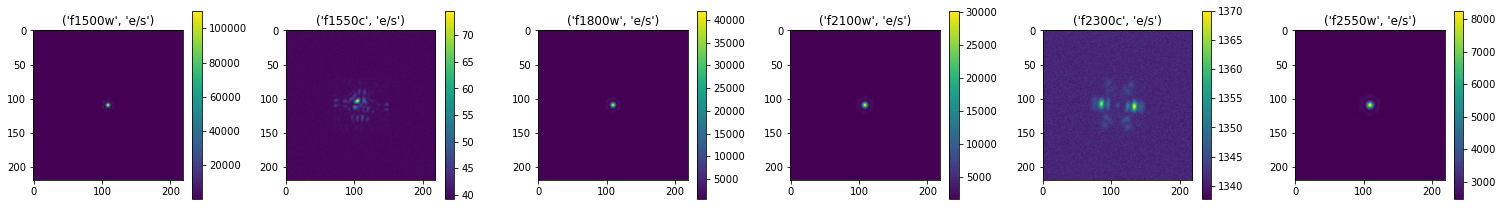

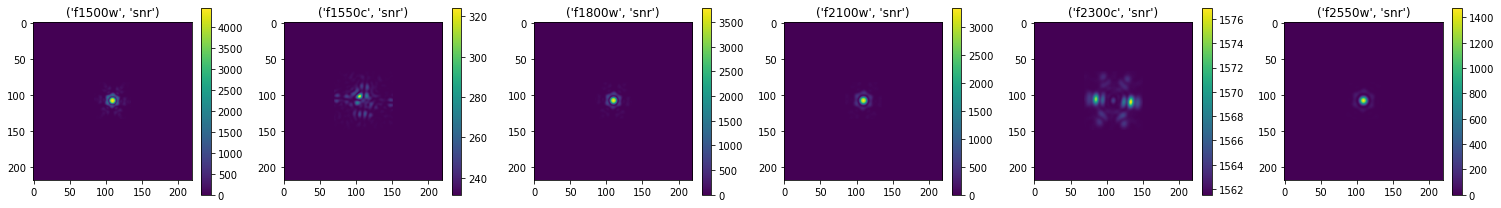

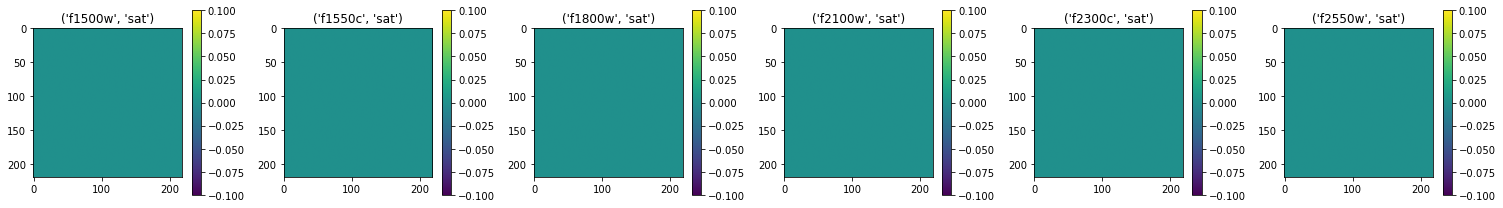

In [16]:
# reference slope images
fig = pd.show_images(ref_slope, title=list(zip(filters,np.tile('e/s',len(filters)))))
fig = pd.show_images(ref_snr, title=list(zip(filters,np.tile('snr',len(filters)))))
fig = pd.show_images(ref_sat, title=list(zip(filters,np.tile('sat',len(filters)))))
fig.savefig(scene_file+'-refsat.pdf')

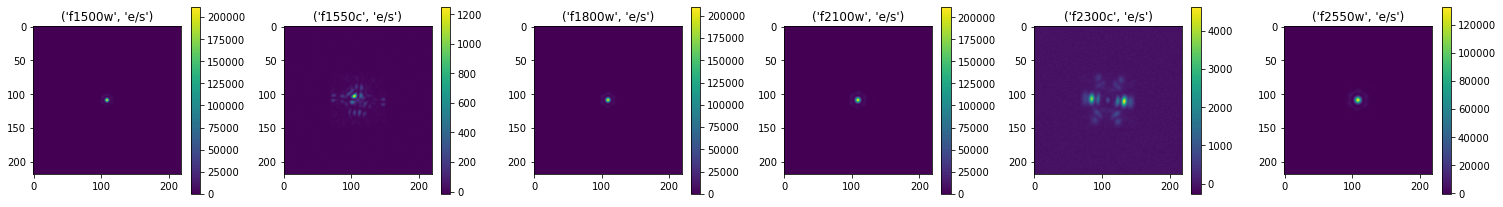

In [17]:
# KLIP PSFs
fig = pd.show_images(klip_ref, title=list(zip(filters,np.tile('e/s',len(filters)))))

## Various subtraction methods

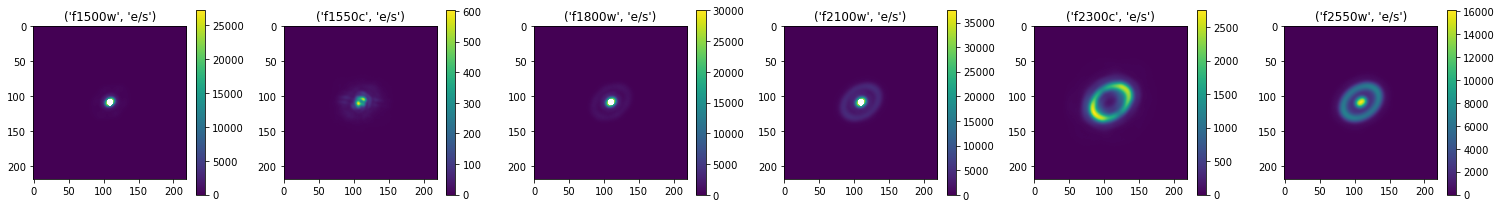

In [18]:
# best-case subtracted images
fig = pd.show_images(bestsub_slope, title=list(zip(filters,np.tile('e/s',len(filters)))))
fig.savefig(scene_file+'-subbest.pdf')

In [19]:
# subtract background
target_slope_bg = target_slope.copy()
star_slope_bg = star_slope.copy()
ref_slope_bg = ref_slope.copy()
tref_slope_bg = tref_slope.copy()
for i,t in enumerate(target_slope):
    target_slope_bg[i] = pd.subtract_background(target_slope[i], aspp=aspp, radius=5)
    star_slope_bg[i] = pd.subtract_background(star_slope[i], aspp=aspp, radius=5)
    ref_slope_bg[i] = pd.subtract_background(ref_slope[i], aspp=aspp, radius=5)
    tref_slope_bg[i] = pd.subtract_background(tref_slope[i], aspp=aspp, radius=5)

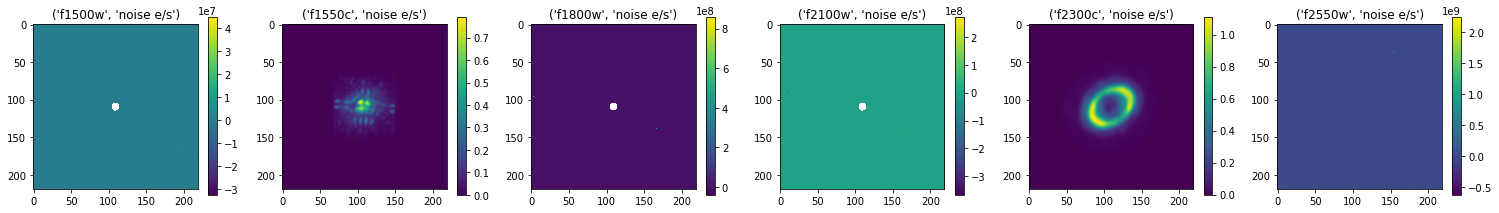

In [20]:
target_noise = [t/s for t,s in zip(target_slope_bg,target_snr)]
fig = pd.show_images(target_noise, title=list(zip(filters,np.tile('noise e/s',len(filters)))))

In [21]:
# bg subtracted images
# fig = pd.show_images(target_slope_bg, title=list(zip(filters,np.tile('e/s',len(filters)))))
# fig = pd.show_images(star_slope_bg, title=list(zip(filters,np.tile('e/s',len(filters)))))
# fig = pd.show_images(ref_slope_bg, title=list(zip(filters,np.tile('e/s',len(filters)))))
# fig = pd.show_images(tref_slope_bg, title=list(zip(filters,np.tile('e/s',len(filters)))))

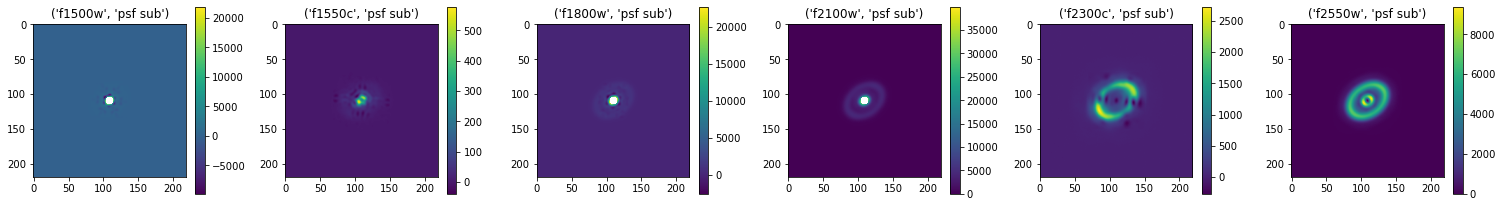

In [22]:
# perfect subtraction, but scaling target star to peak
norm = [np.nanmax(target_slope_bg[i])/np.nanmax(star_slope_bg[i]) for i in range(len(target_slope_bg))]
sub = [r*n for r,n in zip(star_slope_bg, norm)]

fig = pd.show_images(target_slope_bg, sub=sub, title=list(zip(filters,np.tile('psf sub',len(filters)))))
fig.savefig(scene_file+'-subbest_scaled.pdf')
# fig = pd.show_images(target_slope_bg, sub=sub, title=list(zip(filters,np.tile('psf sub',len(filters)))), log=True)

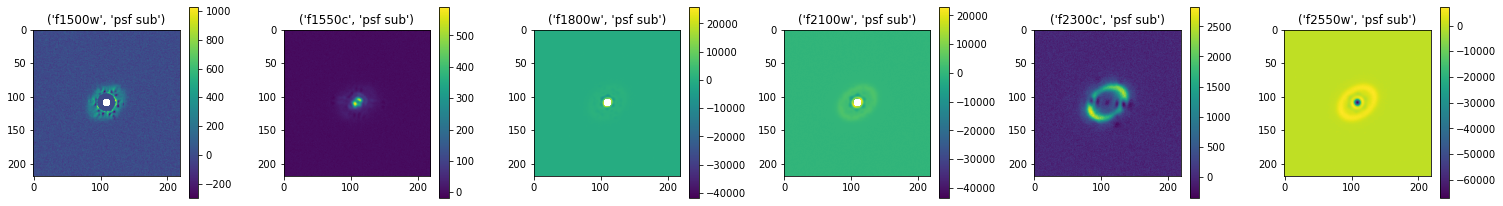

In [23]:
# reference subtraction without recentering, mask saturated region, and when creating these images
sub = []
masks = []
for i in range(len(target_slope_bg)):
    mask = pd.radial_mask(target_slope_bg[i], aspp=aspp, radius=1.5)
    if apertures[i] == 'imager' and filters[i] == 'f1500w':
        masks.append(mask)
    else:
        masks.append(None)
    norm = np.nanmax(target_slope_bg[i][mask])/np.nanmax(ref_slope_bg[i][mask])
    sub.append(ref_slope_bg[i] * norm)

fig = pd.show_images(target_slope_bg, sub=sub, title=list(zip(filters,np.tile('psf sub',len(filters)))), masks=masks)
fig.savefig(scene_file+'-suboffset.pdf')

/Users/grant/Dropbox/astro/proposals/jwst/etc/pandeia-disks/pandisk/pandeia_funcs.py:406: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(im - sub[i])*mask)
/Users/grant/Dropbox/astro/proposals/jwst/etc/pandeia-disks/pandisk/pandeia_funcs.py:406: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(im - sub[i])*mask)


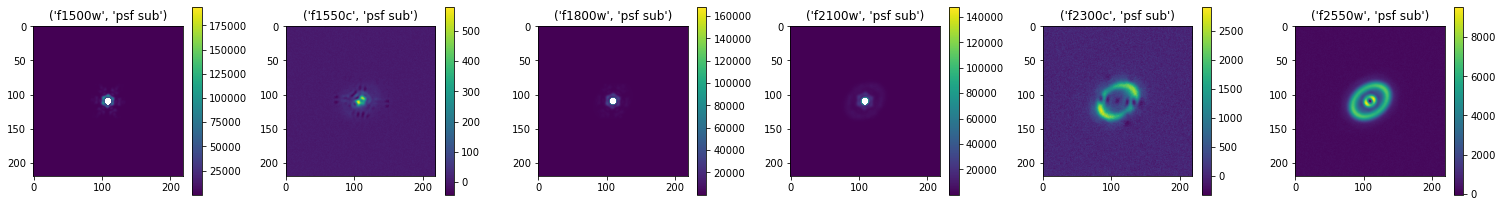

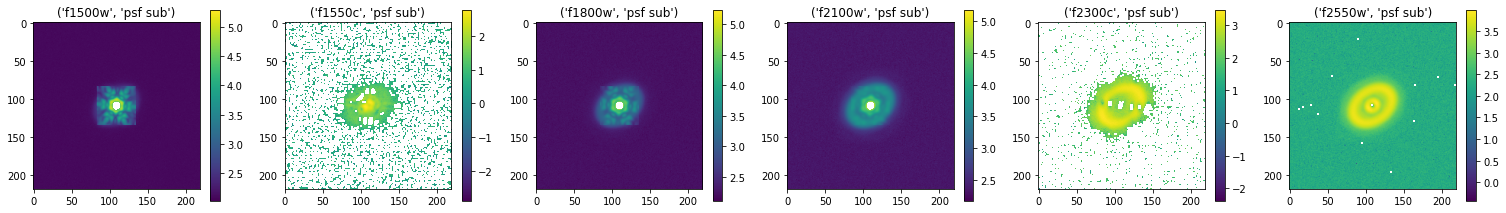

In [24]:
# registered subtraction
reg_ref = []
for c,t,s,r in zip(target, target_slope_bg, star_slope_bg, ref_slope_bg):
    reg_ref1 = pc.analysis.register_to_target(r, t, rescale_reference=True,
                                              mask=np.isfinite(t) & np.isfinite(r))
    if c['configuration']['instrument']['aperture'] == 'imager':
        norm = np.nanmax(t)/np.nanmax(reg_ref1)
    else:
        norm = np.nanmax(t)/np.nanmax(reg_ref1)
    reg_ref.append(reg_ref1 * norm)

fig = pd.show_images(target_slope_bg, sub=reg_ref, title=list(zip(filters,np.tile('psf sub',len(filters)))))
fig.savefig(scene_file+'-subreg.pdf')
fig = pd.show_images(target_slope_bg, sub=reg_ref, title=list(zip(filters,np.tile('psf sub',len(filters)))), log=True)

/Users/grant/Dropbox/astro/proposals/jwst/etc/pandeia-disks/pandisk/pandeia_funcs.py:406: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(im - sub[i])*mask)


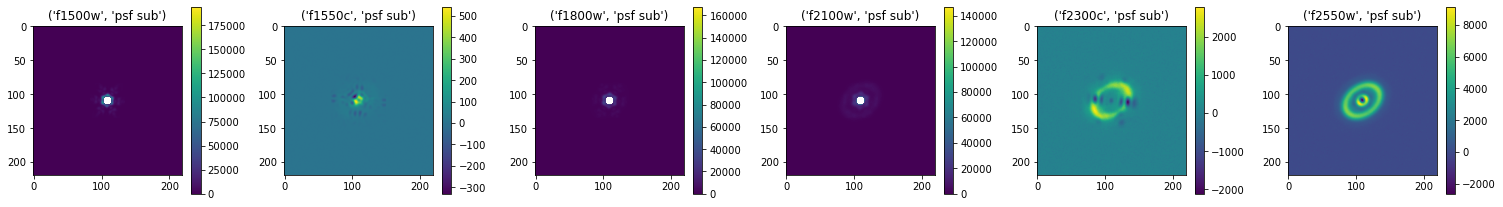

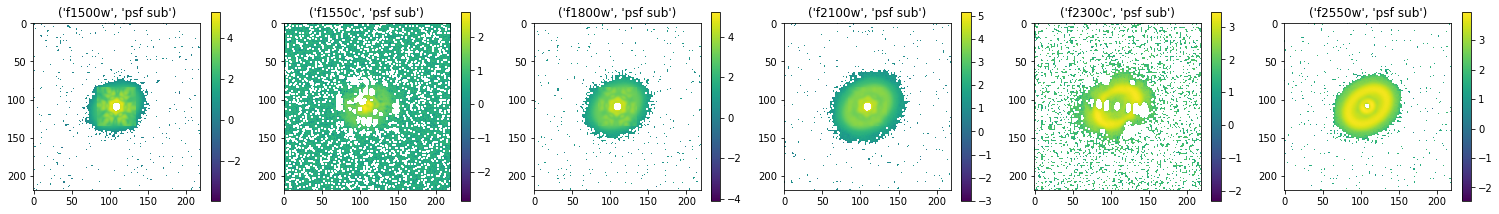

In [25]:
# SGD KLIP PSF (for coronagraphic imaging)
fig = pd.show_images(target_slope_bg, sub=klip_ref, title=list(zip(filters,np.tile('psf sub',len(filters)))))
fig.savefig(scene_file+'-subklip.pdf')
fig = pd.show_images(target_slope_bg, sub=klip_ref, title=list(zip(filters,np.tile('psf sub',len(filters)))), log=True)

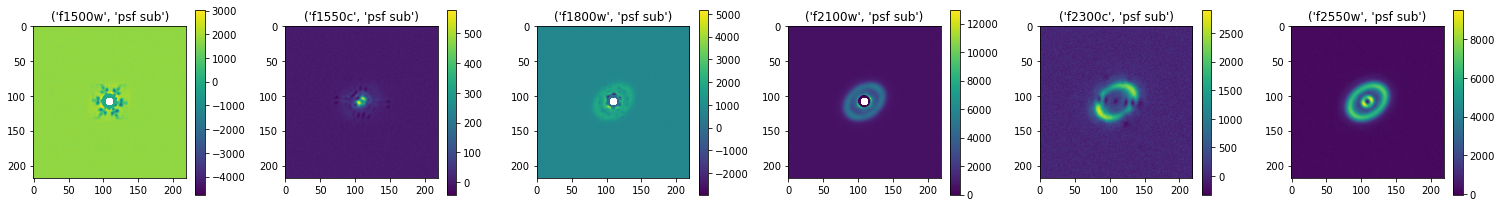

In [26]:
# by-hand scaled subtraction
scale = [14.,1,4.5,2.5,1,1]
ref = [r*n for r,n in zip(reg_ref,scale)]
masks = [None if s==1 else pd.radial_mask(target_slope_bg[0], aspp=aspp, radius=1.) for s in scale]
masks[0] = pd.radial_mask(target_slope_bg[0], aspp=aspp, radius=1.2)

fig = pd.show_images(target_slope_bg, sub=ref, title=list(zip(filters,np.tile('psf sub',len(filters)))), masks=masks)
fig.savefig(scene_file+'-subbyhand.pdf')

In [27]:
# save the results
with open(scene_file+'-pandeia-results.pkl','wb') as f:
    pickle.dump(results, f)